# Solver for the Maxwell-bloch equations w/ phase modulation (modulation swipe).

***

## Equations:

Maxwell-bloch equation, after aproximations, with external phase modulation for $E_y$

$
\begin{cases}
\partial_{\tau} E_x=-k E_x + \mu P_x \\
\partial_{\tau} E_y=-k E_y + \mu P_y + i.(\Delta \phi_0 + m.cos(w_{mod}.\tau)).E_x \\
\partial_{\tau} P_{x,y}=-(1+i\delta)P_{x,y}+E_{x,y}.D \\
\partial_{\tau} D=-\gamma_{||}(D-D_0+\tfrac{1}{2}(E^*_{x,y}P_{x,y}+E_{x,y}P^*_{x,y})) \\
\end{cases}
$


with $ E_{x,y}$ and $P_{x,y}$  $\in \mathbb{C}$

##### Normalizations made: 
$\tau= \gamma_{\bot}.t$, $k=\tfrac{\bar{k}}{\gamma_{\bot}}$,  $\gamma_{\parallel}=\tfrac{\bar{\gamma_{\parallel}}}{\gamma_{\bot}}$, $\eta=\tfrac{z}{L}$, $\delta'_{ac}=\tfrac{w_a-w_0}{\gamma_{\bot}}$


##### Aproximations: 

1-$k,\gamma_{\parallel}<<\gamma_{\bot}$   -- Homogenously broadened laser linewidth $ \nabla^2 E-\frac{1}{c^2}\partial_{t^2}E=\alpha \partial_{t^2}E$

2-Plane wave: $\nabla^2_{\bot}=0$

3-Two level medium

4-Slowly varying amplitud

5-Unidirectional field

6-Rotating wave approx $\partial_{t^2}<<\partial_t$

7-Single longitudinal mode

8-$g'->0$, $R_0->1$  -- Uniform field limit

9-$m$,$w_{mod}<<1$, $w_{mod}<<\gamma_{\bot}$  ..chequear..

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 24 17:05:30 2015

@author: Alexis
"""
import numpy as np
#import scipy as sc
#import matplotlib
import matplotlib.pyplot as plt
#from scipy.integrate import odeint
#from numpy import linspace
#import math
#from matplotlib.collections import LineCollection
from comparefase import comparembfase
from intmbfase import intmbfase as int
#import datetime as dt
from time import localtime
#import time, sys
#import mpld3
from scipy.signal import argrelextrema
import numba

%matplotlib inline


'''---- |2>
    ||
    || R21
    ||
   ---- |1>'''

plt.ion()
pi=np.pi #defino pi


import os
import ipyparallel as ipp

rc = ipp.Client()
ar = rc[:].apply_async(os.getpid)
pid_map = ar.get_dict()

### Parameters

In [2]:
'''parameters for normalization'''
a=2
gperp=10**8. #gamma perpendicular, loss rate
scale=1*(10.**6)/gperp #scale to micro seconds
wscale=1000*gperp/(10.**6)#scale frequency to khz

In [3]:
'''parameters for the equation'''
k=0.9*10.**7/gperp #normalized loss rate
mu=.25*10**(-4) #g
Dphi0=0.0 #phase shift [-pi,pi]
d=1.0 #detuning
g=2.5*10.**4/gperp #*((2*pi)**2) #sigma parallel, normalized loss rate
D0=a*k/mu #Poblation
wf=0.00474342

'''parameters to compare with the results'''
w_res=np.sqrt(k*g*((D0*mu/k)-1.))*wscale #resonance frequency
a=D0*mu/k
w=np.sqrt(k*g*(a-1.)-(g*g*a*a)/4)*wscale #Relaxation oscilations frequency


swiping parameter: m


In [11]:
mmin=0.0370
mmax=0.04
mn=np.arange(mmin, mmax+(mmax-mmin)/80. , (mmax-mmin)/80.)
mn=np.arange(0.035, 0.04+(mmax-mmin)/80. , (mmax-mmin)/80.)+np.arange(mmin, mmax+(mmax-mmin)/80. , (mmax-mmin)/80.) #10 pasos entre la resonancia y 0.1*resonancia

#10 pasos entre la resonancia y 0.1*resonancia
print mn


[ 0.037      0.0370375  0.037075   0.0371125  0.03715    0.0371875
  0.037225   0.0372625  0.0373     0.0373375  0.037375   0.0374125  0.03745
  0.0374875  0.037525   0.0375625  0.0376     0.0376375  0.037675
  0.0377125  0.03775    0.0377875  0.037825   0.0378625  0.0379     0.0379375
  0.037975   0.0380125  0.03805    0.0380875  0.038125   0.0381625  0.0382
  0.0382375  0.038275   0.0383125  0.03835    0.0383875  0.038425
  0.0384625  0.0385     0.0385375  0.038575   0.0386125  0.03865    0.0386875
  0.038725   0.0387625  0.0388     0.0388375  0.038875   0.0389125  0.03895
  0.0389875  0.039025   0.0390625  0.0391     0.0391375  0.039175
  0.0392125  0.03925    0.0392875  0.039325   0.0393625  0.0394     0.0394375
  0.039475   0.0395125  0.03955    0.0395875  0.039625   0.0396625  0.0397
  0.0397375  0.039775   0.0398125  0.03985    0.0398875  0.039925
  0.0399625  0.04       0.0400375]


mmin=0.04
mmax=0.05
mn=np.arange(0., 1+(1)/60. , 1/60.) #n evenly paced steps between 0 and 1.
steep=1.
plt.plot(mn,np.arctan(steep*mn),'.b')
mn=np.arctan(steep*mn) #non linear distribution of parameter
mn=((mmax-mmin)/(pi/2)*mn+mmin) #normalize to the min  and max values i want to use
fig=plt.figure()
plt.plot(mn,np.zeros_like(mn),'.b')
plt.xlabel('m')


## Initial conditions, Integration and variables

In [5]:
#Function for initializing simulations after the transition
def  initial(init, time, y):
    intime=500.*14*10**(-6)*gperp #integration time FOR TRANSITORY
    if init=='new':
        '''User defined initial condition'''
        timeinit = np.arange(0., intime, 1.)
        dfxinit=[1., 1.] 
        dfyinit=[1.,  -1.9]  
        drxinit=[1.,   1.]
        dryinit=[1.,  -1.9] 
        ddeltainit=[6.65973518e+03]
        yinit=np.array(dfxinit+dfyinit+drxinit+dryinit+ddeltainit)
    if init=='l':
        '''initial condition from last simulation'''
        timeinit = np.arange(time[-1] ,intime*5/14+time[-1] , 1.)
        yinit=y[-1]
    return yinit, timeinit
    


In [6]:
@numba.autojit
def swipe(mn,k,mu,Dphi0,d,g,D0,wf):
    steps=2#number of iterations
    peaks=[[0], [0]]
    count=0
    time=np.array([0, 0])
    y=np.array([[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]])
    for j in range(len(mn)):  #loop for frequencys
        wf_real=wf*wscale
        count=count+1
        print count
        for i in range(steps): #for each freq, integrete some time, and then integrate again using the last result as initial condition
            '''initial conditions'''
            if i==0:
                yinit, time=initial('new', time, y)
            if i==1:
                yinit, time=initial('l', time, y)
            '''integration'''
            y, time=int(yinit,time,k,mu,Dphi0,d,g,D0,mn[j],wf)
        '''intensitys'''
        intensity_ex=np.sqrt(y[:,0]**2+y[:,1]**2)
        intensity_ey=np.sqrt(y[:,2]**2+y[:,3]**2)
        intensity=np.sqrt(y[:,0]**2+y[:,1]**2+y[:,2]**2+y[:,3]**2)
        '''peaks'''
        peak_coor=argrelextrema(intensity, np.greater)#find peaks index
        peak_max=list(set(intensity[argrelextrema(intensity, np.greater)[0]]))#intensity peaks
        m_peaks=list(mn[j]*np.ones_like(peak_max))#vector or m, the same lenght as peak_max
        peaks[0]=peaks[0]+m_peaks
        peaks[1]=peaks[1]+peak_max
        
    return peaks

In [7]:
wf_real=wf*scale

In [8]:
peaks=swipe(mn,k,mu,Dphi0,d,g,D0,wf)

1

[-0.089974999999999999, -0.089974999999999999, -0.019675000000000012, 0.20795249999999998, 6659.7351799999997, 6657.7351799999997, 6656.83518, -12652.596841999999, 0.13341370499999985]
[5.7585217156726984e-10, 6.3845794194842394e-10, 0.0066234945783653094, 0.0014133800551448723, 4.1677768221950532e-06, 3.9498587048831049e-07, 74.804106498038607, -45.872093985277161, 0.12683523092064844]
2

[-0.089974999999999999, -0.089974999999999999, -0.019603750000000003, 0.20798999999999998, 6659.7351799999997, 6657.7351799999997, 6656.83518, -12652.596841999999, 0.13341370499999985]
[-1.1032473476069891e-09, 1.2370738142169607e-09, 0.0011619221461255387, 0.0066591490624429523, 1.1414211730879909e-07, 8.0701089485722325e-06, 70.454601994147197, 52.199086194620179, 0.12688493929716282]
3

[-0.089974999999999999, -0.089974999999999999, -0.019532499999999994, 0.20802749999999998, 6659.7351799999997, 6657.7351799999997, 6656.83518, -12652.596841999999, 0.13341370499999985]
[1.0843481892192346e-09, 1

C:\Users\Alexis\Anaconda\lib\site-packages\numba\dataflow.py:297: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


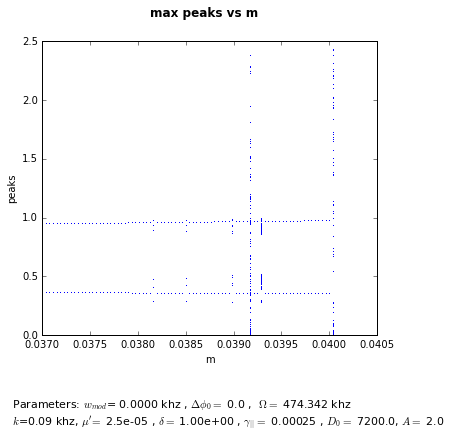

In [9]:
'''plots'''
save=True #set True if i want to save files automatically
       
fig_bif=plt.figure()
fig_bif.suptitle('max peaks vs m', fontsize=12, fontweight='bold')
ax2 = fig_bif.add_subplot(111)
ax2.plot(peaks[0][1:],peaks[1][1:],',b')
ax2.set_xlabel('m')
ax2.set_ylabel('peaks')
plt.text(-0.1,-.32, "\n Parameters: $w_{mod}$= %.4f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.3f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax2.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig_bif.set_size_inches(6, 6)
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-max_vs_m.png' % localtime()[0:6]
    fig_bif.savefig(fname, dpi = 300)# when saving, specify the DPI

import simplejson
>>> f = open('peaks.txt', 'w')
>>> simplejson.dump(peaks, f)
>>> f.close()

In [36]:
#fig5=plt.figure()
#ax1 = fig5.add_subplot(111)
#f1=plt.plot(time,y[:,0])
#f1=plt.plot(time,y[:,2])
#fig5.suptitle('E_x  & E_y vs tiempo', fontsize=12, fontweight='bold')
#ax1.set_xlabel('time(ms) ')
#ax1.set_ylabel('E ')
#plt.xlim(min(time), max(time))
#plt.text(-0.1,-1.04, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax3.transAxes)   
#plt.subplots_adjust(bottom=0.22)
#fig1.savefig('moduloE_fasemodulada.png')


In [37]:
'''comparison between the solution with and without modulation'''
def comp():
    comparembfase(y,yinit,time,k,mu,Dphi0,d,g,D0,m,wf)

#comp()

Notebook style:

In [38]:
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())